# Imports

In [1]:
import src.utils as utils
import src.defect_free_dsm as blc
import src.disclinated_dsm as disc

import numpy as np
from numpy import pi, cos, sin

import networkx as netx

import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time

# Define Pauli and Gamma matrices for convenience
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

gamma_0 = np.kron(sigma_0, sigma_0)
gamma_1 = np.kron(sigma_x, sigma_z)
gamma_2 = np.kron(-sigma_y, sigma_0)
gamma_3 = np.kron(sigma_z, sigma_0)
gamma_4 = np.kron(sigma_x, sigma_x)
gamma_5 = np.kron(sigma_x, sigma_y)

In [2]:
def disclination_graph(nx: int):
    graph = netx.Graph()

    if nx % 2 == 0:
        site_mod = 0
    else:
        site_mod = 1

    for ii in range(nx):
        for jj in range(nx):
            # x-hoppings
            if jj < nx // 2 + site_mod:
                if ii < nx - 1:
                    graph.add_edge((ii, jj), (ii + 1, jj))
            else:
                if ii < nx // 2 - 1:
                    graph.add_edge((ii, jj), (ii + 1, jj))
            # y-hoppings
            if ii < nx // 2:
                if jj < nx - 1:
                    graph.add_edge((ii, jj), (ii, jj + 1))
            else:
                if jj < nx // 2 - 1 + site_mod:
                    graph.add_edge((ii, jj), (ii, jj + 1))

    for ii in range(nx // 2):
        graph.add_edge((nx // 2 + ii + site_mod, nx // 2 - 1 + site_mod), (nx // 2 - 1, nx // 2 + ii + site_mod))

    pos = netx.kamada_kawai_layout(graph)

    return graph, pos


def plot_disclination_rho(rho: np.ndarray, n_x: int, subtract_background=False, close_disc=True):

    if len(rho.shape) != 1:
        n_kz = rho.shape[0]
        dk = 2 * pi / n_kz
        rho = np.sum(rho, axis=0) * dk

    if subtract_background:
        data = rho - np.mean(rho)
    else:
        data = rho

    dmax = np.max(np.abs(data))
    normalized_data = data / dmax

    # Generate list of lattice sites and positions
    x = []
    y = []
    graph, pos = disclination_graph(n_x)

    # Order the node list by the x index so the plot makes sense
    ordered_nodes = list(graph.nodes)
    ordered_nodes.sort(key=lambda s: s[1])

    for site in ordered_nodes:
        if close_disc:
            coords = pos[site]
        else:
            coords = site
        x.append(coords[0])
        y.append(coords[1])

    # Plot charge density
    fig, ax = plt.subplots(figsize=(6, 4))
    marker_scale = 250
    if subtract_background:
        im = ax.scatter(x, y, s=marker_scale * np.abs(normalized_data), c=data, cmap='bwr', marker='o', vmax=dmax,
                        vmin=-dmax)
    else:
        im = ax.scatter(x, y, s=marker_scale * np.abs(normalized_data), c=data, cmap='Reds', marker='o')

    ax.scatter(x, y, s=2, c='black')
    ax.set_aspect('equal')

    cbar = utils.add_colorbar(im, aspect=15, pad_fraction=1.0)
    cbar.ax.set_title(r'$|\rho|$', size=14)
    cbar.ax.tick_params(labelsize=14)

    ax.margins(x=0.2)

    plt.axis('off')
    plt.tight_layout()
    
    return fig, ax

# Defect-free bands and spectral function

In [9]:
n_cdw = 2
delta_cdw = 0.5
phi_cdw = 0.0
cdw_matrix = gamma_3
bond_centered = True

cdw_params = {'n' : n_cdw, 'delta' : delta_cdw, 'phi' : phi_cdw, 'matrix' : cdw_matrix, 'bond_centered' : bond_centered}

q = pi / n_cdw
b_xy = 1.0

model_params = {'q' : q, 'b_xy' : b_xy}

n_z = n_cdw * (200 // n_cdw)
pbc = True

100%|██████████| 100/100 [00:10<00:00,  9.17it/s]


Momentum space band gap    = 2.00000 eV
Coordinate space band gap  = 2.00000 eV
Diff                       = 0.00000 eV


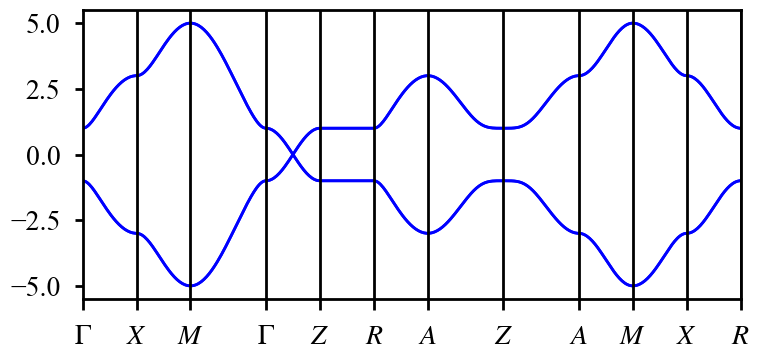

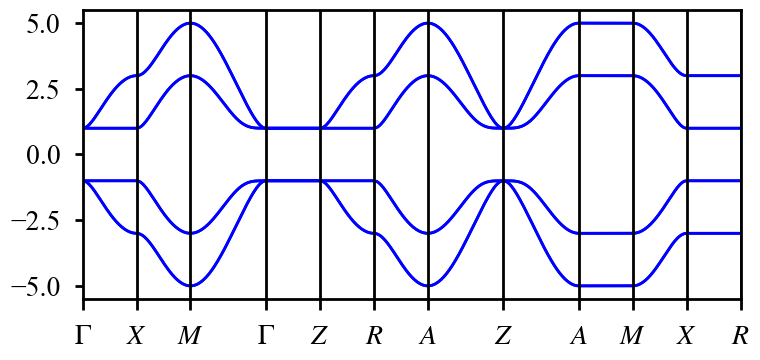

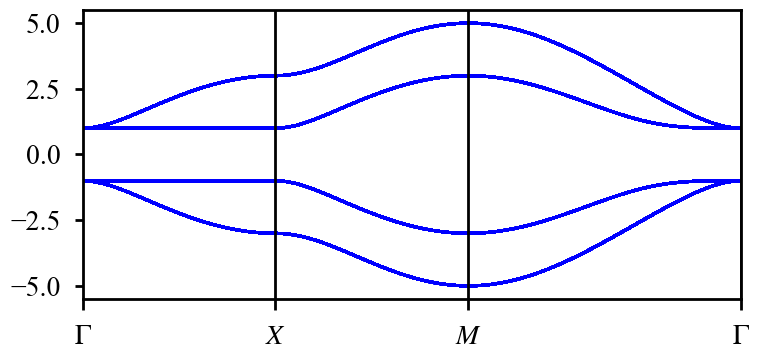

In [10]:
n_k_bloch = 500
n_k_z_coord = 100

fig_1, ax_1, bloch_evals = blc.plot_band_structure(n_k_bloch, model_params, None)

fig_2, ax_2, cdw_bloch_evals = blc.plot_band_structure(n_k_bloch, model_params, cdw_params)

fig_3, ax_3, z_coord_evals = blc.plot_z_coord_band_structure(n_k_z_coord, n_z, pbc, model_params, cdw_params)

momentum_band_edge = np.min(np.abs(cdw_bloch_evals))
z_coord_band_edge = np.min(np.abs(z_coord_evals))

print(f'Momentum space band gap    = {2 * momentum_band_edge:.5f} eV')
print(f'Coordinate space band gap  = {2 * z_coord_band_edge:.5f} eV')
print(f'Diff                       = {2 * np.abs(momentum_band_edge - z_coord_band_edge):.5f} eV')

plt.show()

In [ ]:
e_min = -0.5
e_max = 0.5
e_pts = 200

energy_axis = np.linspace(e_min, e_max, e_pts)

de = energy_axis[1] - energy_axis[0]
eta = 1.5 * de

n_kx = 70
n_ky = 70
n_kz = 50

n_ks = (n_kx, n_ky, n_kz)

no_cdw_ldos, no_cdw_dos = blc.calculate_bloch_dos(energy_axis, eta, n_ks, model_params, None)

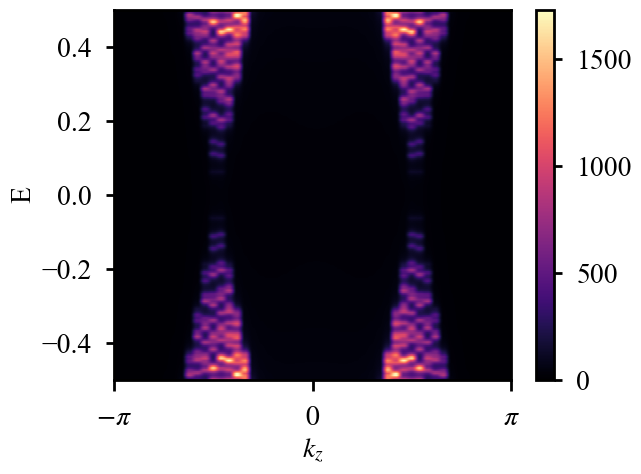

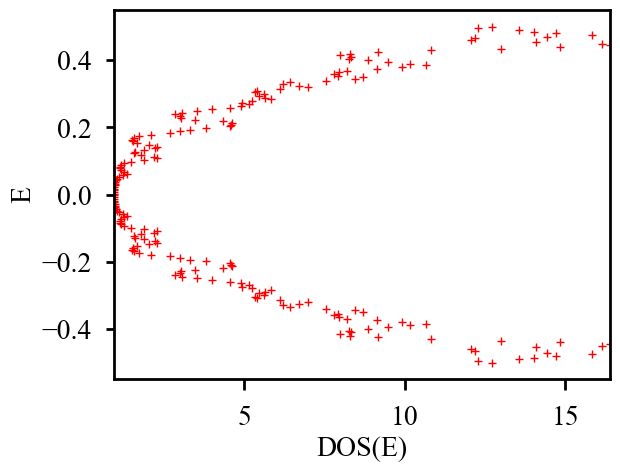

In [6]:
fig1, ax1 = plt.subplots()

data = np.sum(no_cdw_ldos, axis=(1, 2))

c = ax1.imshow(data, cmap='magma', aspect='auto', origin='lower', extent=(-pi, pi, e_min, e_max), vmin=0)

ax1.set_ylabel('E')

ax1.set_xticks([-pi, 0, pi])
ax1.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
ax1.set_xlabel(r'$k_z$')

cbar = plt.colorbar(c)

fig2, ax1 = plt.subplots()

c = ax1.plot(no_cdw_dos, energy_axis, 'r+')

ax1.set_ylabel('E')
ax1.set_xlabel('DOS(E)')

plt.show()


# DSM spectrum and bound charge on a disclinated lattice

In [11]:
e_min = -0.5
e_max = 0.5
e_pts = 100

energy_axis = np.linspace(e_min, e_max, e_pts)

de = energy_axis[1] - energy_axis[0]
eta = 1.0 * de

n_kz = 200
n_x = 11

no_cdw_disc_ldos = disc.disc_ldos_in_k(energy_axis, eta, n_kz, n_x, model_params, None)

100%|██████████| 200/200 [02:35<00:00,  1.28it/s]


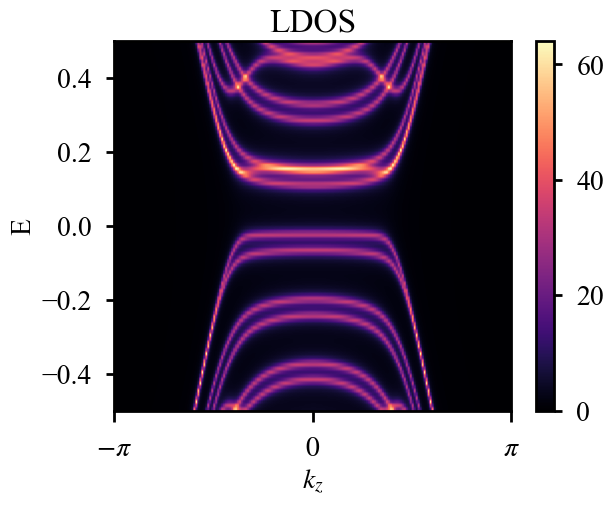

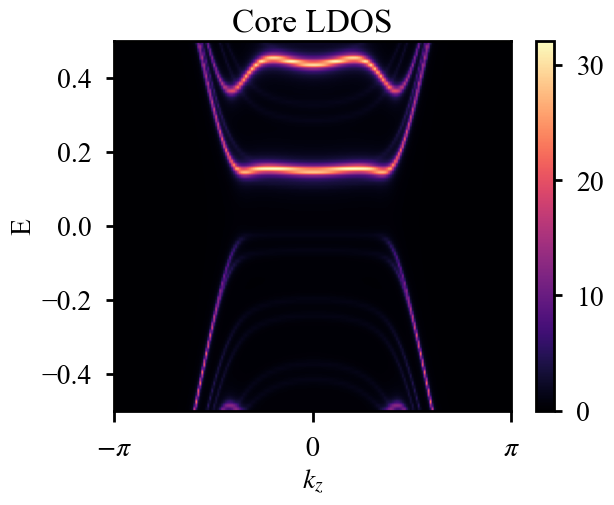

In [12]:
threshold = 3
bound_ldos = disc.bound_ldos_in_k(n_x, threshold, no_cdw_disc_ldos)

# Plot the LDOS
fig1, ax1 = plt.subplots()

data = np.sum(no_cdw_disc_ldos, axis=-1)
c = ax1.imshow(data, cmap='magma', aspect='auto', origin='lower', extent=(-pi, pi, e_min, e_max), vmin=0)

ax1.set_ylabel('E')

ax1.set_xticks([-pi, 0, pi])
ax1.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
ax1.set_xlabel(r'$k_z$')

ax1.set_title('LDOS')
cbar = plt.colorbar(c)

# Plot LDOS on the core
fig2, ax2 = plt.subplots()

data = bound_ldos
c = ax2.imshow(data, cmap='magma', aspect='auto', origin='lower', extent=(-pi, pi, e_min, e_max), vmin=0)

ax2.set_ylabel('E')

ax2.set_xticks([-pi, 0, pi])
ax2.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
ax2.set_xlabel(r'$k_z$')

ax2.set_title('Core LDOS')

cbar = plt.colorbar(c)

In [13]:
n_kz = 200
n_x = 19

rho = disc.disc_rho_in_k(n_kz, n_x, model_params, None)

100%|██████████| 200/200 [01:18<00:00,  2.56it/s]


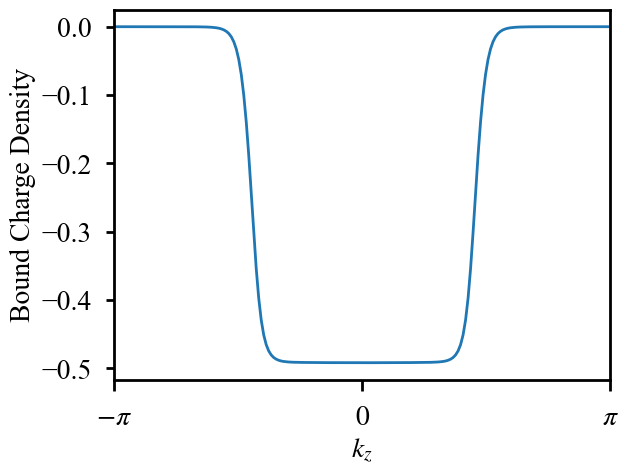

In [16]:
threshold = n_x // 4
dk = 2 * pi / n_kz

bound_charge_density_in_k = disc.bound_charge_density_in_k(n_x, threshold, rho)

bound_charge_density = np.sum(bound_charge_density_in_k) * dk

k_ax = np.linspace(-pi, pi, n_kz)

fig, ax = plt.subplots()

ax.plot(k_ax, bound_charge_density_in_k)

ax.set_xlabel(r'$k_z$')
ax.set_xticks((-pi, 0, pi))
ax.set_xticklabels((r'$-\pi$', r'$0$', r'$\pi$'))

ax.set_ylabel('Bound Charge Density')

plt.tight_layout

plt.show()

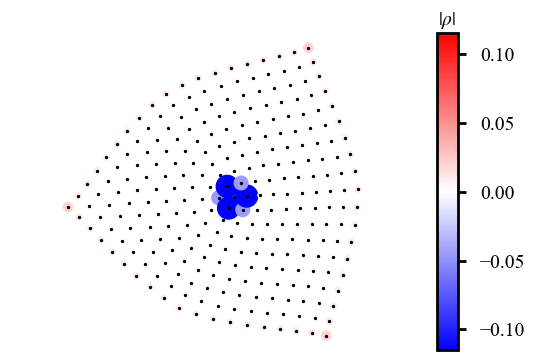

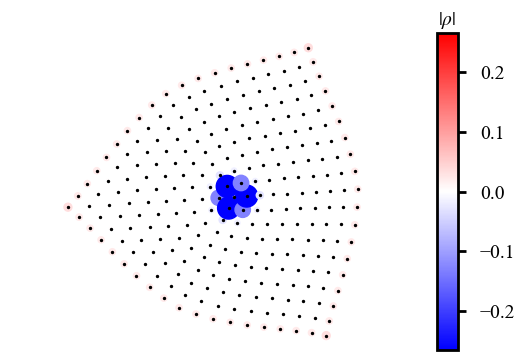

In [17]:
k_val = 0.0
k_ind = np.argmin(np.abs(k_ax - k_val))

fig, ax = plot_disclination_rho(rho[k_ind], n_x, subtract_background=True)

plt.tight_layout()

plt.show()

fig, ax = plot_disclination_rho(rho, n_x, subtract_background=True)

plt.tight_layout()

plt.show()

# Check bound charge density vs Q for sanity

In [51]:
q_0 = q

q_min = 0.2 * pi
q_max = 0.8 * pi
q_pts = 5

q_ax = np.linspace(q_min, q_max, q_pts)

n_x = 25
n_kz = 100
dk = 2 * pi / n_kz

rho = []
bound_charge_density_in_k = np.zeros((q_pts, n_kz))

for ii in tqdm(range(len(q_ax))):
    q = q_ax[ii]

    model_params['q'] = q
    rho.append(disc.disc_rho_in_k(n_kz, n_x, model_params, None, verbose=False))

q = q_0
model_params['q'] = q_0


100%|██████████| 5/5 [10:37<00:00, 127.51s/it]


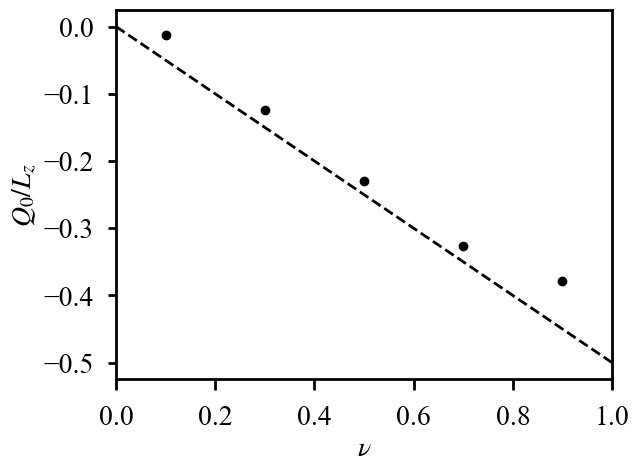

In [57]:
threshold = n_x // 4
slope_guess = -1 / 2

for ii in range(len(rho)):
    bound_charge_density_in_k[ii] = disc.bound_charge_density_in_k(n_x, threshold, rho[ii])

bound_charge_density = np.sum(bound_charge_density_in_k, axis=-1) / n_kz

fig, ax = plt.subplots()

v_axis = 2 * q_ax / ( 2 * pi)
ax.plot(v_axis, bound_charge_density, 'ok')

v_axis = np.linspace(0, 1, 10)
ax.plot(v_axis, slope_guess * v_axis, 'k--')

ax.set_xlabel(r'$\nu$')
ax.set_xlim(left=0, right=1)

ax.set_ylabel(r'$Q_0 / L_z$')

plt.tight_layout

plt.show()

# DSM + CDW spectral function on a disclinated lattice

In [18]:
n_cdw = 2
delta_cdw = 0.5
phi_cdw = 0.0
cdw_matrix = gamma_3
bond_centered = True

cdw_params = {'n' : n_cdw, 'delta' : delta_cdw, 'phi' : phi_cdw, 'matrix' : cdw_matrix, 'bond_centered' : bond_centered}

q = pi / n_cdw
b_xy = 1.0

model_params = {'q' : q, 'b_xy' : b_xy}

In [19]:
e_min = -1.5
e_max = 1.5
e_pts = 100
energy_axis = np.linspace(e_min, e_max, e_pts)
de = energy_axis[1] - energy_axis[0]
eta = 1.5 * de

n_kz = 100

n_x = 11

cdw_disc_ldos = disc.disc_ldos_in_k(energy_axis, eta, n_kz, n_x, model_params, cdw_params)

100%|██████████| 100/100 [06:40<00:00,  4.00s/it]


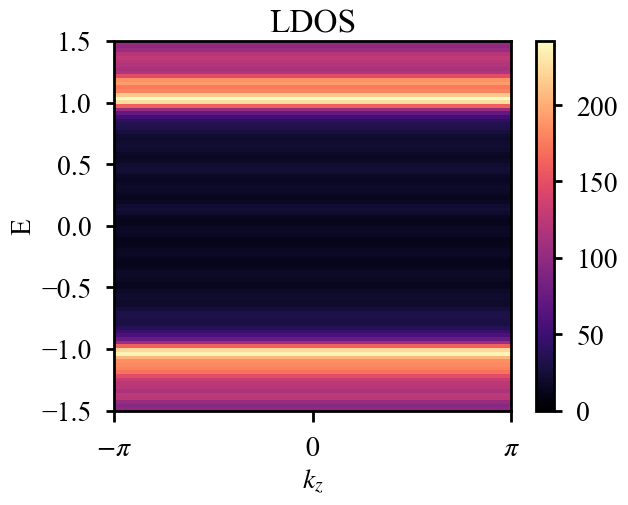

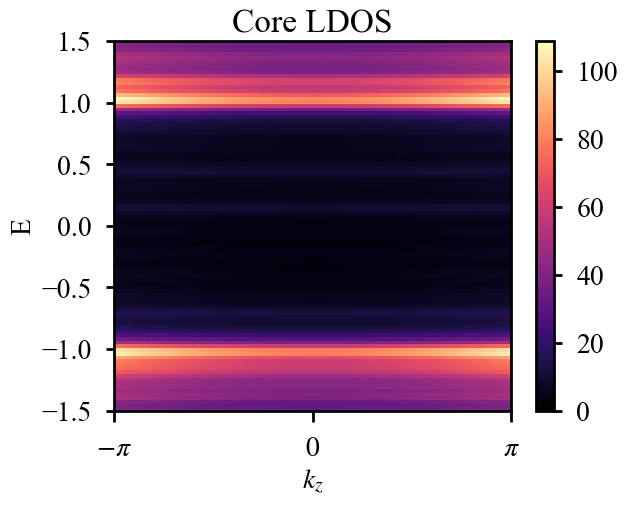

In [20]:
threshold = n_x // 4
bound_ldos = disc.bound_ldos_in_k(n_x, threshold, cdw_disc_ldos)

# Plot the LDOS
fig1, ax1 = plt.subplots()

data = np.sum(cdw_disc_ldos, axis=-1)
c = ax1.imshow(data, cmap='magma', aspect='auto', origin='lower', extent=(-pi, pi, e_min, e_max), vmin=0)

ax1.set_ylabel('E')

ax1.set_xticks([-pi, 0, pi])
ax1.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
ax1.set_xlabel(r'$k_z$')

ax1.set_title('LDOS')
cbar = plt.colorbar(c)

# Plot LDOS on the core
fig2, ax2 = plt.subplots()

data = bound_ldos
c = ax2.imshow(data, cmap='magma', aspect='auto', origin='lower', extent=(-pi, pi, e_min, e_max), vmin=0)

ax2.set_ylabel('E')

ax2.set_xticks([-pi, 0, pi])
ax2.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
ax2.set_xlabel(r'$k_z$')

ax2.set_title('Core LDOS')

cbar = plt.colorbar(c)

# Check bound charge density vs Q with the CDW

In [135]:
n_x = 12
n_kz = 100

rho = disc.disc_rho_in_k(n_kz, n_x, model_params, cdw_params, verbose=True)

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


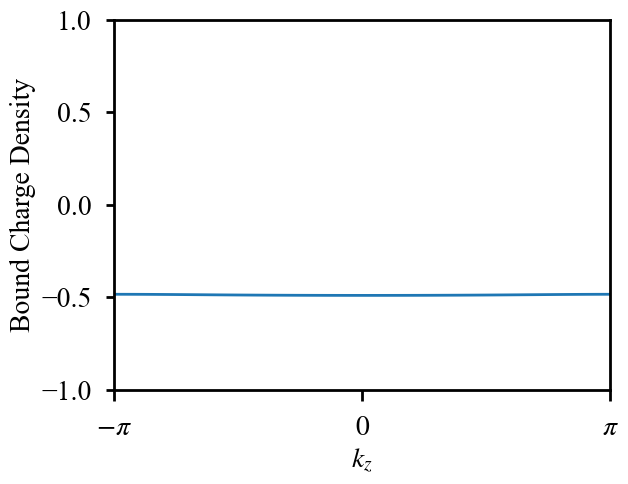

In [136]:
threshold = n_x // 4

bound_charge_density_in_k = disc.bound_charge_density_in_k(n_x, threshold, rho)

k_ax = np.linspace(-pi, pi, n_kz)

fig, ax = plt.subplots()

ax.plot(k_ax, bound_charge_density_in_k)

ax.set_xlabel(r'$k_z$')
ax.set_xticks((-pi, 0, pi))
ax.set_xticklabels((r'$-\pi$', r'$0$', r'$\pi$'))

ax.set_ylabel('Bound Charge Density')
ax.set_ylim(bottom=-1, top = 1)

plt.tight_layout

plt.show()

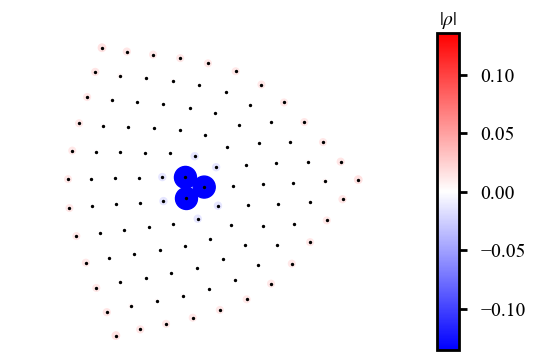

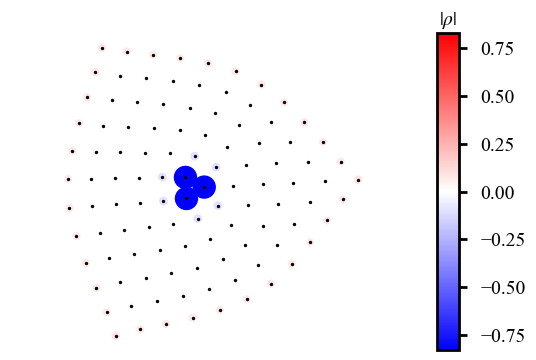

In [137]:
k_val = 0
k_ind = np.argmin(np.abs(k_ax - k_val))

fig, ax = plot_disclination_rho(rho[k_ind], n_x, subtract_background=True)

plt.tight_layout()

plt.show()

fig, ax = plot_disclination_rho(rho, n_x, subtract_background=True)

plt.tight_layout()

plt.show()

In [138]:
threshold = n_x // 4

bound_charge_density_in_k = disc.bound_charge_density_in_k(n_x, threshold, rho)
bound_charge = np.sum(bound_charge_density_in_k)

print(f'          bound_charge = {bound_charge:.2f}')
print(f'bound charge per layer = {bound_charge / (n_cdw * n_kz):.3f}')
print(f'expectation            = {-1 / (2 * n_cdw):.3f}')

          bound_charge = -49.69
bound charge per layer = -0.166
expectation            = -0.167


# Check bound charge with open and periodic BCs for DSM + CDW

In [21]:
n_cdw = 2
delta_cdw = 0.5
phi_cdw = 0.0
cdw_matrix = gamma_3
bond_centered = True

cdw_params = {'n' : n_cdw, 'delta' : delta_cdw, 'phi' : phi_cdw, 'matrix' : cdw_matrix, 'bond_centered' : bond_centered}

q = pi / n_cdw
b_xy = 1.0

model_params = {'q' : q, 'b_xy' : b_xy}

In [22]:
n_z = 10 * n_cdw
n_x = 12

tic = time()
pos_pbc_rho = disc.disc_rho_in_z(n_z, True, n_x, model_params, cdw_params)
print(f'Finished calculating rho with PBCs and phi=0 at t = {time() - tic:.2f}')

pos_obc_rho = disc.disc_rho_in_z(n_z, False, n_x, model_params, cdw_params)
print(f'Finished calculating rho with OBCs and phi=0 at t = {time() - tic:.2f}')

cdw_params['phi'] = pi

neg_pbc_rho = disc.disc_rho_in_z(n_z, True, n_x, model_params, cdw_params)
print(f'Finished calculating rho with PBCs and phi=pi at t = {time() - tic:.2f}')

neg_obc_rho = disc.disc_rho_in_z(n_z, False, n_x, model_params, cdw_params)
print(f'Finished calculating rho with OBCs and phi=pi. t = {time() - tic:.2f}')

cdw_params['phi'] = 0.0

Finished calculating rho with PBCs and phi=0 at t = 58.38
Finished calculating rho with OBCs and phi=0 at t = 116.19
Finished calculating rho with PBCs and phi=pi at t = 173.75
Finished calculating rho with OBCs and phi=pi. t = 231.38


In [23]:
theshold = n_x // 4
threshold = 3

pos_pbc_bound_charge = disc.bound_charge_density_in_z(n_x, threshold, pos_pbc_rho)
pos_obc_bound_charge = disc.bound_charge_density_in_z(n_x, threshold, pos_obc_rho)
neg_pbc_bound_charge = disc.bound_charge_density_in_z(n_x, threshold, neg_pbc_rho)
neg_obc_bound_charge = disc.bound_charge_density_in_z(n_x, threshold, neg_obc_rho)

print(f'Total charge with phi = 0.0 and PBC: {np.sum(pos_pbc_bound_charge):.2f}')
print(f'Total charge with phi = 0.0 and OBC: {np.sum(pos_obc_bound_charge):.2f}')
print(f'Total charge with phi = pi and PBC: {np.sum(neg_pbc_bound_charge):.2f}')
print(f'Total charge with phi = pi and OBC: {np.sum(neg_obc_bound_charge):.2f}')

print('')
print(f'Expectation for PBCs: {1 / 4 * n_z}')

Total charge with phi = 0.0 and PBC: -4.49
Total charge with phi = 0.0 and OBC: -4.45
Total charge with phi = pi and PBC: -4.49
Total charge with phi = pi and OBC: -4.45

Expectation for PBCs: 5.0


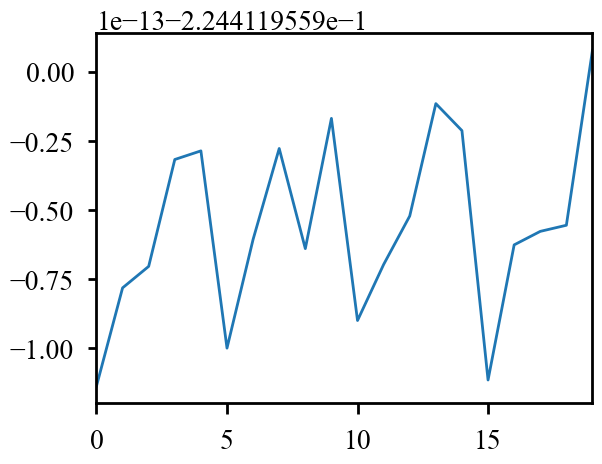

In [24]:
plt.plot(pos_pbc_bound_charge)
plt.show()